import packages

In [1]:
import glob
import os

# data/plot management
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import warnings

# plotting/mapmaknig
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow

# adding 'custom script' 
#Ensure the [Pyeto](https://github.com/woodcrafty/PyETo) package is present in your 
# "C:\Users\{USERNAME}\anaconda3\envs\{ENVIRONMENT}\Lib\",or "C:\Users\{USERNAME}\anaconda3\Lib\",
from pyeto import thornthwaite, monthly_mean_daylight_hours, deg2rad

from scipy.optimize import root

warnings.simplefilter('ignore')

add some useful paths to navigate shared storage:

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
main_folder = os.path.dirname(home_path)

gis_folder = f'{main_folder}\\QGIS project'

add some spatial data

In [3]:
country_outline = gpd.read_file(f"{gis_folder}\\country_outline_32630.gpkg")
volta_outline = gpd.read_file(f"{gis_folder}\\volta_watershed_vector_32630.gpkg",crs="epsg:32630")
main_rivers = gpd.read_file(f"{gis_folder}\\main_rivers_volta.gpkg",crs="epsg:32630")
all_rivers_bf = gpd.read_file(f"{gis_folder}\\all_river_in_volta_basin_bf.gpkg",crs="epsg:32630")

country_outline = country_outline.set_geometry(country_outline.geometry.to_crs('EPSG:4326'))
volta_outline = volta_outline.set_geometry(volta_outline.geometry.to_crs('EPSG:4326'))
main_rivers = main_rivers.set_geometry(main_rivers.geometry.to_crs('EPSG:4326'))
all_rivers_bf = all_rivers_bf.set_geometry(all_rivers_bf.geometry.to_crs('EPSG:4326'))

gdf_precip = gpd.read_file('precipitation_data_client_new.geojson',crs="EPSG:4326")
gdf_discharge_client = gpd.read_file('discharge_data_client.geojson',crs="EPSG:4326")
gdf_discharge_client['name'] = gdf_discharge_client.apply(lambda x: x['name'].split(",")[-1][:-4].strip().lower(),axis=1)

In [4]:
gdf_discharge_client

,name,lat,lon,geometry
0,vonkoro,9.171205,-2.744841,POINT (-2.74484 9.17121)
1,dan,10.867876,-3.722479,POINT (-3.72248 10.86788)
2,samandeni,11.458715,-4.469477,POINT (-4.46948 11.45872)
3,dapola,10.572862,-2.914135,POINT (-2.91413 10.57286)
4,yakala,11.344608,-0.528965,POINT (-0.52897 11.34461)
5,yilou,12.999710,-1.570603,POINT (-1.57060 12.99971)
6,dakaye,11.777456,-1.600156,POINT (-1.60016 11.77746)
7,porga,11.045433,0.959914,POINT (0.95991 11.04543)
8,samboali,11.279537,1.015889,POINT (1.01589 11.27954)


# make general:

#### load precipitation data from analysis

In [5]:
Rainfall_BF_msum = pd.read_excel("Monthly_sum_rainfall_new.xlsx",index_col=0)
Rainfall_BF_msum.columns

Index(['Black_Volta', 'Lake_Volta', 'Mouhoun', 'Nakambe', 'Oti', 'Penjari'], dtype='object')

In [6]:
Rainfall_BF_msum

,Black_Volta,Lake_Volta,Mouhoun,Nakambe,Oti,Penjari
Date,,,,,,
1979-01-31,0.07,22.16,0.00,0.00,2.11,0.00
1979-02-28,0.19,8.30,0.00,0.00,0.12,0.00
1979-03-31,34.61,112.79,16.96,1.08,67.49,21.70
1979-04-30,67.99,91.50,6.50,1.10,108.33,30.42
1979-05-31,153.06,220.44,106.28,36.68,138.56,81.21
...,...,...,...,...,...,...
2017-06-30,169.74,227.13,149.20,136.69,180.13,145.87
2017-07-31,50.46,167.42,217.97,146.42,189.20,201.37
2017-08-31,124.00,59.13,220.91,207.12,177.32,195.82


#### load discharge data from analysis

In [7]:
names = ['black volta, vonkoro',
         'bougouriba, dan',
         'mou houn, black volta, samandeni',
         'mou houn, black volta,dapola',
         'nakanbe, white volta, yakala',
         'nakanbe, white volta, yilou',
         'nazinon, red volta, dakaye',
         'pendjari, porga',
         'singou, samboali']

need a dictionary to link discharge to precipitation stations

In [8]:
q_p_linking_dictionary = {'black volta, vonkoro': 'Black_Volta',
                          'bougouriba, dan': 'Mouhoun',
                          'mou houn, black volta, samandeni': 'Mouhoun',
                          'mou houn, black volta,dapola': 'Black_Volta',
                          'nakanbe, white volta, yakala': 'Nakambe',
                          'nakanbe, white volta, yilou': 'Nakambe',
                          'nazinon, red volta, dakaye': 'Nakambe',
                          'pendjari, porga': 'Penjari',
                          'singou, samboali': 'Penjari'}

In [9]:
df_discharge_per_location_lst = []
for name in names:
    df_discharge = pd.read_excel(f"{home_path}\\Combining data\\{name}.xlsx",index_col=0)
    df_discharge_per_location_lst.append(df_discharge)

## E

historic temperature data downloaded from [CMIP6](https://storage.googleapis.com/cmip6/pangeo-cmip6.json) model from NOAA-GFDL - 

In [10]:
df_temperature = pd.read_excel(f"{home_path}\\Evaporation\\daily_Near-Surface-Air-Temperature.xlsx",
# df_temperature = pd.read_excel(f"{home_path}\\Evaporation\\mean_monthly_Near-Surface-Air-Temperature.xlsx",
                       index_col=0, parse_dates=True)
df_temperature.rename(columns={0:"Temperature"},inplace=True)
df_temperature_msum = df_temperature.resample('M').mean()

`dakaye` was chosen to as fairly centrally located

In [11]:
lat = deg2rad(gdf_discharge_client[gdf_discharge_client['name']=="dakaye"].iloc[0].geometry.y)

In [12]:
years = df_temperature_msum.index.year.unique()
for year in years:
    mmdlh = monthly_mean_daylight_hours(lat, year)
    # use thornthwaite to calculate the 
    evap = thornthwaite(df_temperature_msum[f'{year}'].Temperature.to_list(), mmdlh, year=year)
    set_items = df_temperature_msum[f'{year}'].index
    df_temperature_msum.loc[set_items,"evap"] = evap

# some function

In [13]:
def plot_combined_df(combined_df):    
    """Plots the combined_dfs constructed"""
    fig, ax = plt.subplots(1)
    ax.set_xlabel("Date")
    ax.set_ylabel("$m^3/month$")
    for val in ["P","Q","E"]:
        combined_df[val].plot(marker='.',lw=0.5, ax=ax,label=val)

    combined_df["Diff"].plot(ax=ax,label="Difference")
    ax.get_xlim()
    ax.set_title(f"Water balance")
    ax.legend()
    ax.axhline(0, alpha=0.2, ls="--", color="C4" )

In [14]:
FACTOR_EA_EP_W = 0.3664
FACTOR_EA_EP_D = 0.1188

In [15]:
output_river = all_rivers_bf.copy()

# now run per river segment:

In [16]:
for index, row in all_rivers_bf.iterrows():
    # get the centre of each segment
    centre = row.geometry.centroid
    # find nearest precipitation station:
    closest_station_index = gdf_precip.distance(centre).argmin()
    name_of_closest_station = gdf_precip.loc[closest_station_index, "name"]
    selected_rain_data = Rainfall_BF_msum[[name_of_closest_station]].rename(columns={name_of_closest_station:"P"})
    
    #prepare evaporation data
    df_temperature_msum.rename(columns={'evap':'E'},inplace=True)
    area_basin = row.UPLAND_SKM * 10**6
    
    # adjust potential to actuall evaporation
    mask = ((df_temperature_msum.index.month >= 5) & (df_temperature_msum.index.month <= 11))
    df_growing = df_temperature_msum[mask]
    df_dry = df_temperature_msum[~mask]

    df_growing_f = FACTOR_EA_EP_W * df_growing[["E"]] /1000 # mm/month * m^2 ->/1000 
    df_dry_f     = FACTOR_EA_EP_D * df_dry[["E"]]/1000 # mm/month * m^2 ->/1000 

    df_combining_evap = pd.concat([df_growing_f,df_dry_f])
    combined_df = df_combining_evap.sort_index()

    # combine everything:
    combined_df["P"] = selected_rain_data["P"] * area_basin /1000 # mm/month * m^2 ->/1000 
    combined_df["Q"] = combined_df["P"] - combined_df["E"]
    combined_df = combined_df.loc[combined_df.P.dropna().index]
    combined_df = combined_df[combined_df["Q"] >= 0]
    combined_df = combined_df.resample('M').mean()

    combined_df['Q_ms'] = combined_df.apply(lambda x: x.Q / (x.name.days_in_month * 24 * 3600), axis=1)
#     combined_df["Q"].plot(marker='.', lw=1)

    # also look at dry vs growin season 
    mask = ((combined_df.index.month >= 5) & (combined_df.index.month <= 11))
    df_growing = combined_df[mask][['Q_ms']]
    df_dry = combined_df[~mask][['Q_ms']]
    
    # store the data per feature
    output_river.loc[index,"MIN_1981_2014_M3_S"]   = combined_df['Q_ms'].min()
    output_river.loc[index,"MAX_1981_2014_M3_S"]   = combined_df['Q_ms'].max()
    output_river.loc[index,"MEAN_1981_2014_M3_S"]  = combined_df['Q_ms'].mean()
    
    
    output_river.loc[index,"MEAN_1981_2014_DRY"]      = df_dry['Q_ms'].mean()
    output_river.loc[index,"MIN_1981_2014_DRY"]       = df_dry['Q_ms'].min()
    output_river.loc[index,"MEAN_1981_2014_WET"]      = df_growing['Q_ms'].mean()
    output_river.loc[index,"MAX_1981_2014_WET"]       = df_growing['Q_ms'].max()
    
    

In [17]:
combined_df

,E,P,Q,Q_ms
time,,,,
1979-01-31,0.006840,3955.0,3.954993e+03,0.001477
1979-02-28,0.010794,10735.0,1.073499e+04,0.004437
1979-03-31,0.021219,1955465.0,1.955465e+06,0.730087
1979-04-30,0.022004,3841435.0,3.841435e+06,1.482035
1979-05-31,0.071014,8647890.0,8.647890e+06,3.228752
...,...,...,...,...
2014-07-31,0.053834,4205295.0,4.205295e+06,1.570077
2014-08-31,0.044558,7385680.0,7.385680e+06,2.757497
2014-09-30,0.043391,9829870.0,9.829870e+06,3.792388


In [18]:
output_river.head(1)

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,...,ORD_FLOW,HYBAS_L12,geometry,MIN_1981_2014_M3_S,MAX_1981_2014_M3_S,MEAN_1981_2014_M3_S,MEAN_1981_2014_DRY,MIN_1981_2014_DRY,MEAN_1981_2014_WET,MAX_1981_2014_WET
0,10482758,10483017,10821582,2.43,1763.0,9.5,15.19,15.2,0,0.002,...,9,1121891670,"LINESTRING (-2.41667 14.26458, -2.42292 14.264...",0.000059,1.72555,0.36899,0.022397,0.000059,0.462244,1.72555


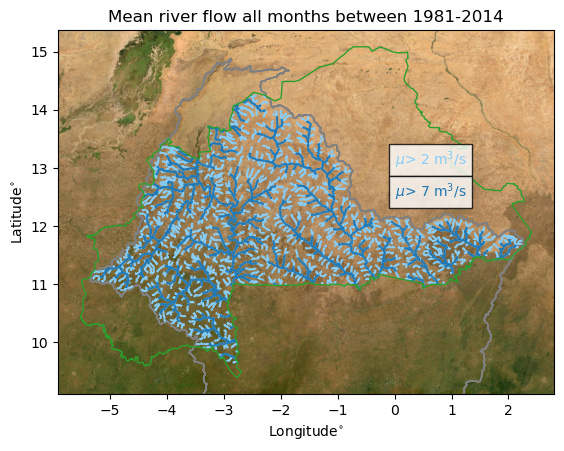

In [19]:
fig,ax = plt.subplots(1)
country_outline.plot(ax=ax, facecolor="none", edgecolor="C2",zorder=6)
bounds= (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
volta_outline.plot(ax=ax,edgecolor="k", facecolor='none')
# add background
with rasterio.open(get_background_map("rivers", bounds)) as r:
    rioshow(r, ax=ax)
    
ax.set_xlim(bounds[0],bounds[2])
ax.set_ylim(bounds[1],bounds[3])
stats = output_river["MEAN_1981_2014_M3_S"].describe()
output_river[output_river["MEAN_1981_2014_M3_S"]>stats[f'50%']].plot(ax=ax,color=f'lightskyblue')
legend1 = ax.annotate(f"$\mu$> {stats[f'50%']:.1g} m$^3$/s", (0,13.05),color='lightskyblue',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
output_river[output_river["MEAN_1981_2014_M3_S"]>stats[f'75%']].plot(ax=ax,color=f'C0')
legend2 = ax.annotate(f"$\mu$> {stats[f'75%']:.1g} m$^3$/s", (0,12.5),color='C0',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)

legend1.set_bbox(dict(facecolor='w', alpha=0.8))
legend2.set_bbox(dict(facecolor='w', alpha=0.8))
    
ax.set_xlabel("Longitude$^{\circ}$");
ax.set_ylabel("Latitude$^{\circ}$");
ax.set_title("Mean river flow all months between 1981-2014")

fig.savefig('rivers_flow.png', transparent=True)

In [20]:
def plot_value(header, title):
    fig,ax = plt.subplots(1)
    country_outline.plot(ax=ax, facecolor="none", edgecolor="C2",zorder=6)
    bounds= (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
    volta_outline.plot(ax=ax,edgecolor="k", facecolor='none')

    # add background
    with rasterio.open(get_background_map("rivers", bounds)) as r:
        rioshow(r, ax=ax)

    ax.set_xlim(bounds[0],bounds[2])
    ax.set_ylim(bounds[1],bounds[3])
    stats = output_river[header].describe()
    output_river[output_river[header]>stats[f'50%']].plot(ax=ax,color=f'lightskyblue')
    legend1 = ax.annotate(f"$\mu$> {stats[f'50%']:.1g} m$^3$/s", (0,13.05),color='lightskyblue',zorder=10)#,
    #            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
    output_river[output_river[header]>stats[f'75%']].plot(ax=ax,color=f'C0')
    legend2 = ax.annotate(f"$\mu$> {stats[f'75%']:.1g} m$^3$/s", (0,12.5),color='C0',zorder=10)#,
    #            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)

    legend1.set_bbox(dict(facecolor='w', alpha=0.8))
    legend2.set_bbox(dict(facecolor='w', alpha=0.8))

    ax.set_xlabel("Longitude$^{\circ}$");
    ax.set_ylabel("Latitude$^{\circ}$");
    ax.set_title(title)

    fig.savefig(f'rivers_flow {title}.png', transparent=True)

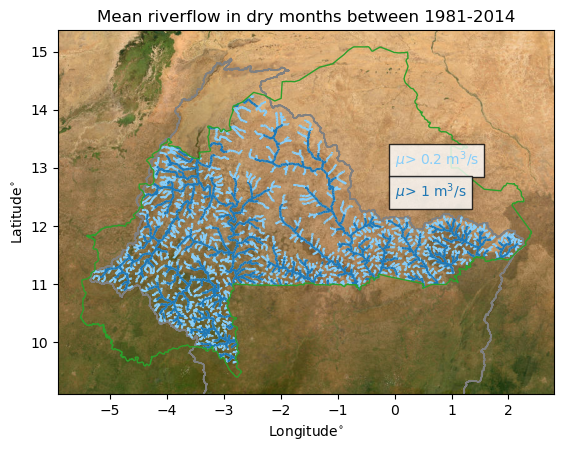

In [21]:
plot_value("MEAN_1981_2014_DRY","Mean riverflow in dry months between 1981-2014")

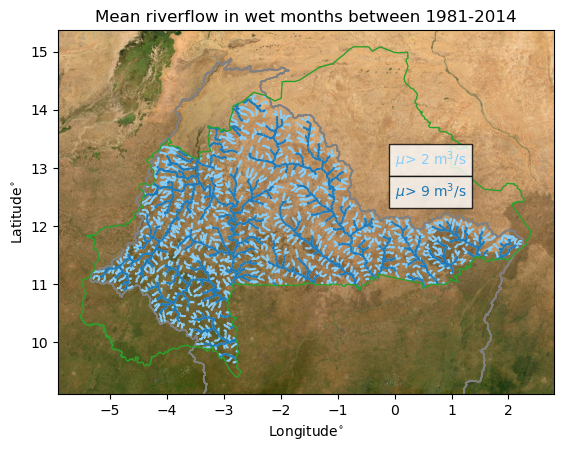

In [22]:
plot_value("MEAN_1981_2014_WET","Mean riverflow in wet months between 1981-2014")

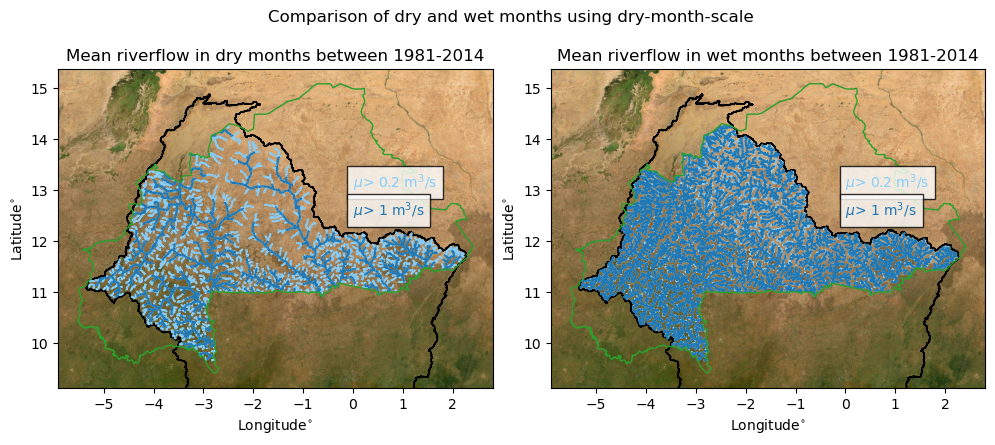

In [23]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()
fig.suptitle("Comparison of dry and wet months using dry-month-scale",y=1.07)
for axs in ax:
    country_outline.plot(ax=axs, facecolor="none", edgecolor="C2",zorder=6)
    bounds= (axs.get_xlim()[0], axs.get_ylim()[0], axs.get_xlim()[1], axs.get_ylim()[1])
    volta_outline.plot(ax=axs,edgecolor="k", facecolor='none')
    # add background
    with rasterio.open(get_background_map("rivers", bounds)) as r:
        rioshow(r, ax=axs)

    axs.set_xlim(bounds[0],bounds[2])
    axs.set_ylim(bounds[1],bounds[3])
    
    axs.set_xlabel("Longitude$^{\circ}$");
    axs.set_ylabel("Latitude$^{\circ}$");
    
ax[0].set_title("Mean riverflow in dry months between 1981-2014")   
header1 = "MEAN_1981_2014_DRY"
stats1 = output_river[header1].describe()
output_river[output_river[header1]>stats1[f'50%']].plot(ax=ax[0],color=f'lightskyblue')
legend1 = ax[0].annotate(f"$\mu$> {stats1[f'50%']:.1g} m$^3$/s", (0,13.05),color='lightskyblue',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
output_river[output_river[header1]>stats1[f'75%']].plot(ax=ax[0],color=f'C0')
legend2 = ax[0].annotate(f"$\mu$> {stats1[f'75%']:.1g} m$^3$/s", (0,12.5),color='C0',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
legend1.set_bbox(dict(facecolor='w', alpha=0.8))
legend2.set_bbox(dict(facecolor='w', alpha=0.8))

ax[1].set_title("Mean riverflow in wet months between 1981-2014")   
header2 = "MEAN_1981_2014_WET"
stats2 = output_river[header2].describe()
output_river[output_river[header2]>stats1[f'50%']].plot(ax=ax[1],color=f'lightskyblue')
legend1 = ax[1].annotate(f"$\mu$> {stats1[f'50%']:.1g} m$^3$/s", (0,13.05),color='lightskyblue',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
output_river[output_river[header2]>stats1[f'75%']].plot(ax=ax[1],color=f'C0')
legend2 = ax[1].annotate(f"$\mu$> {stats1[f'75%']:.1g} m$^3$/s", (0,12.5),color='C0',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
legend1.set_bbox(dict(facecolor='w', alpha=0.8))
legend2.set_bbox(dict(facecolor='w', alpha=0.8))


# fig.savefig(f'rivers_flow {title}.png', transparent=True)

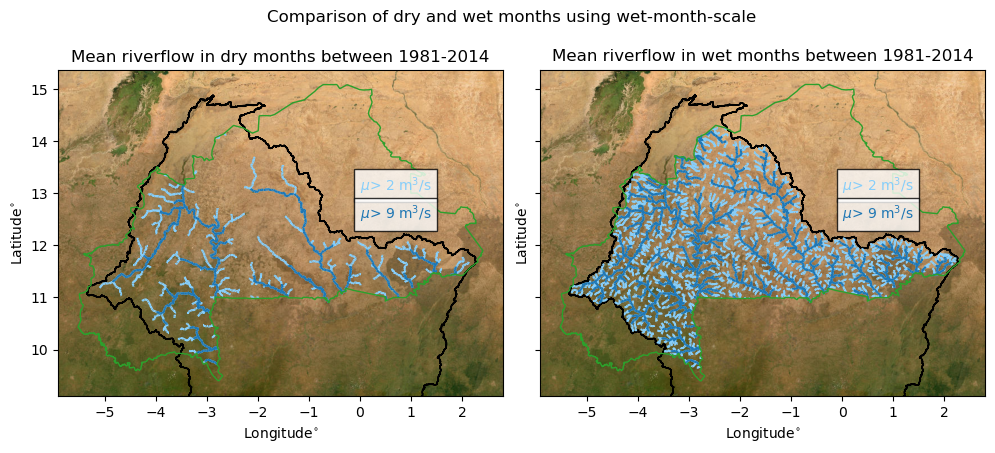

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,4), sharey=True)
fig.tight_layout()
fig.suptitle("Comparison of dry and wet months using wet-month-scale",y=1.08)
for axs in ax:
    country_outline.plot(ax=axs, facecolor="none", edgecolor="C2",zorder=6)
    bounds= (axs.get_xlim()[0], axs.get_ylim()[0], axs.get_xlim()[1], axs.get_ylim()[1])
    volta_outline.plot(ax=axs,edgecolor="k", facecolor='none')
    # add background
    with rasterio.open(get_background_map("rivers", bounds)) as r:
        rioshow(r, ax=axs)

    axs.set_xlim(bounds[0],bounds[2])
    axs.set_ylim(bounds[1],bounds[3])
    
    axs.set_xlabel("Longitude$^{\circ}$");
    axs.set_ylabel("Latitude$^{\circ}$");

    
ax[1].set_title("Mean riverflow in wet months between 1981-2014")   
header2 = "MEAN_1981_2014_WET"
stats2 = output_river[header2].describe()
output_river[output_river[header2]>stats2[f'50%']].plot(ax=ax[1],color=f'lightskyblue')
legend1 = ax[1].annotate(f"$\mu$> {stats2[f'50%']:.1g} m$^3$/s", (0,13.05),color='lightskyblue',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
output_river[output_river[header2]>stats2[f'75%']].plot(ax=ax[1],color=f'C0')
legend2 = ax[1].annotate(f"$\mu$> {stats2[f'75%']:.1g} m$^3$/s", (0,12.5),color='C0',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
legend1.set_bbox(dict(facecolor='w', alpha=0.8))
legend2.set_bbox(dict(facecolor='w', alpha=0.8))

ax[0].set_title("Mean riverflow in dry months between 1981-2014")   
header1 = "MEAN_1981_2014_DRY"
stats1 = output_river[header1].describe()
output_river[output_river[header1]>stats2[f'50%']].plot(ax=ax[0],color=f'lightskyblue')
legend1 = ax[0].annotate(f"$\mu$> {stats2[f'50%']:.1g} m$^3$/s", (0,13.05),color='lightskyblue',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
output_river[output_river[header1]>stats2[f'75%']].plot(ax=ax[0],color=f'C0')
legend2 = ax[0].annotate(f"$\mu$> {stats2[f'75%']:.1g} m$^3$/s", (0,12.5),color='C0',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
legend1.set_bbox(dict(facecolor='w', alpha=0.8))
legend2.set_bbox(dict(facecolor='w', alpha=0.8))

# fig.savefig(f'rivers_flow {title}.png', transparent=True)

KeyError: 'MEAN_1981_2014_WET_MAX'

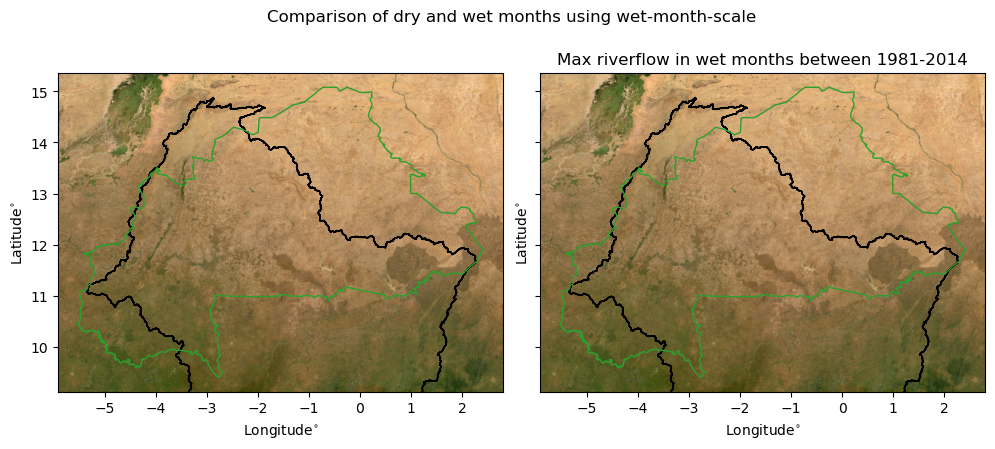

In [25]:
fig, ax = plt.subplots(1,2,figsize=(10,4), sharey=True)
fig.tight_layout()
fig.suptitle("Comparison of dry and wet months using wet-month-scale",y=1.08)
for axs in ax:
    country_outline.plot(ax=axs, facecolor="none", edgecolor="C2",zorder=6)
    bounds= (axs.get_xlim()[0], axs.get_ylim()[0], axs.get_xlim()[1], axs.get_ylim()[1])
    volta_outline.plot(ax=axs,edgecolor="k", facecolor='none')
    # add background
    with rasterio.open(get_background_map("rivers", bounds)) as r:
        rioshow(r, ax=axs)

    axs.set_xlim(bounds[0],bounds[2])
    axs.set_ylim(bounds[1],bounds[3])
    
    axs.set_xlabel("Longitude$^{\circ}$");
    axs.set_ylabel("Latitude$^{\circ}$");

    
ax[1].set_title("Max riverflow in wet months between 1981-2014")   
header2 = "MEAN_1981_2014_WET_MAX"
stats2 = output_river[header2].describe()
output_river[output_river[header2]>10].plot(ax=ax[1],color=f'lightskyblue')
legend1 = ax[1].annotate(f"$\mu$> {10} m$^3$/s", (0,13.05),color='lightskyblue',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
output_river[output_river[header2]>20].plot(ax=ax[1],color=f'C0')
legend2 = ax[1].annotate(f"$\mu$> {20} m$^3$/s", (0,12.5),color='C0',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
legend1.set_bbox(dict(facecolor='w', alpha=0.8))
legend2.set_bbox(dict(facecolor='w', alpha=0.8))

ax[0].set_title("Min riverflow in dry months between 1981-2014")   
header1 = "MEAN_1981_2014_DRY_MIN"
stats1 = output_river[header1].describe()
print(stats1)
output_river[output_river[header1]>0.01].plot(ax=ax[0],color=f'lightskyblue')
legend1 = ax[0].annotate(f"$\mu$> {0.01} m$^3$/s", (0,13.05),color='lightskyblue',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
output_river[output_river[header1]>0.1].plot(ax=ax[0],color=f'C0')
legend2 = ax[0].annotate(f"$\mu$> {0.1} m$^3$/s", (0,12.5),color='C0',zorder=10)#,
#            path_effects=[matplotlib.patheffects.withStroke(linewidth=0.25, foreground="k")],zorder=10)
legend1.set_bbox(dict(facecolor='w', alpha=0.8))
legend2.set_bbox(dict(facecolor='w', alpha=0.8))

# fig.savefig(f'rivers_flow {title}.png', transparent=True)

In [ ]:
series = output_river["MEAN_1981_2014_M3"]/30/24/3600
series.describe()

In [ ]:
2e7/30/24/3600

In [ ]:
output = True
if output:
    output_river.to_file(f"{gis_folder}\\all_river_in_volta_basin_bf_with_Q.gpkg",crs="epsg:4326")